In [1]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(os.path.dirname(current_dir), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [27]:
import torch
import torch.nn as nn

import numpy as np 

import matplotlib.pyplot as plt

import time

from pinns import Trainer
from pinns.models import FF, KAN
from pinns.errors import l2
from pinns.optimizers import Adam
from pinns.derivatives import Derivative
from pinns.samplers import RandomSampler, ConstantSampler, DataSampler

from prettytable import PrettyTable

In [28]:
def analytical(t):
    return torch.exp(-0.4*t)*(4.59*torch.sin(1.96*t) + 5*torch.cos(1.96*t))

T = 10              # We need to fix some computational domain.
p = (0.2, 2.0)      # Parameters that yields interesting function.
x0, v0 = 5.0, 7.0   # Initial values may be arbitrary.

t = torch.linspace(0, T, 128)
solution = analytical(t)

In [29]:
from pinns.samplers import ConstantSampler, RandomSampler

# Constraints (training data) sampler must return tuple (points, values).
constraints_sampler = ConstantSampler((
    torch.tensor([[0.]], requires_grad=True),
    torch.tensor([x0, v0])
))

# Collocation sampler must return just tensor of shape [num_pts, coords].
domain = {'t': [0, T]}
collocation_sampler = RandomSampler(domain, 256, return_dict=False)

# Test points sampler must return tuple (points, values) of shape [num_pts, coords].
test_points_sampler = ConstantSampler(
    (t.reshape(-1, 1), solution.reshape(-1, 1))
    )

In [30]:
d = Derivative(method = 'autograd')

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred,
    zeta = 0.2, omega = 2.0
    ):
    
    def init_loss(x0, t0):
        v0 = d(x0, t0)
        return torch.mean(torch.square(torch.hstack([x0, v0]) - cstr_vals))

    def ode_loss(x, t):
        v, a = d(x, t, orders = [1, 2])
        return torch.mean(torch.square(a + 2 * zeta * omega * v + omega**2 * x))
    
    losses = (
        init_loss(cstr_pred, cstr_pts),
        ode_loss(coll_pred, coll_pts)
    )
    
    return losses

In [40]:
pinn = KAN([1, 5, 5, 5, 1], grid = 20)

adam = Adam(pinn, lr = 1e-2)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs=[0.8, 0.2],    # Coefficients are very important.
    test_points_sampler=test_points_sampler
)

trainer.train(
    num_iters=1500,
    optimizers=[(0, adam)]
)

  0%|          | 0/1500 [00:00<?, ?it/s]

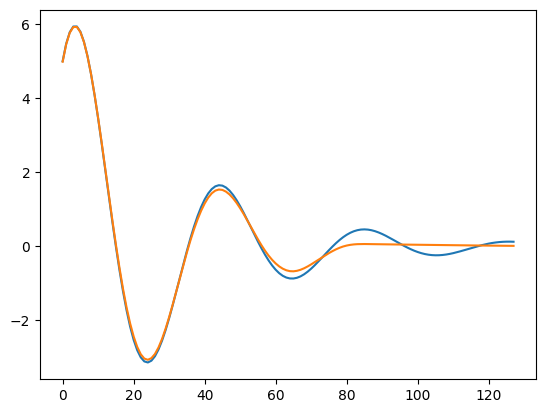

In [32]:
test, _ = test_points_sampler()
preds = pinn.predict(test).detach()
plt.plot(solution)
plt.plot(preds)

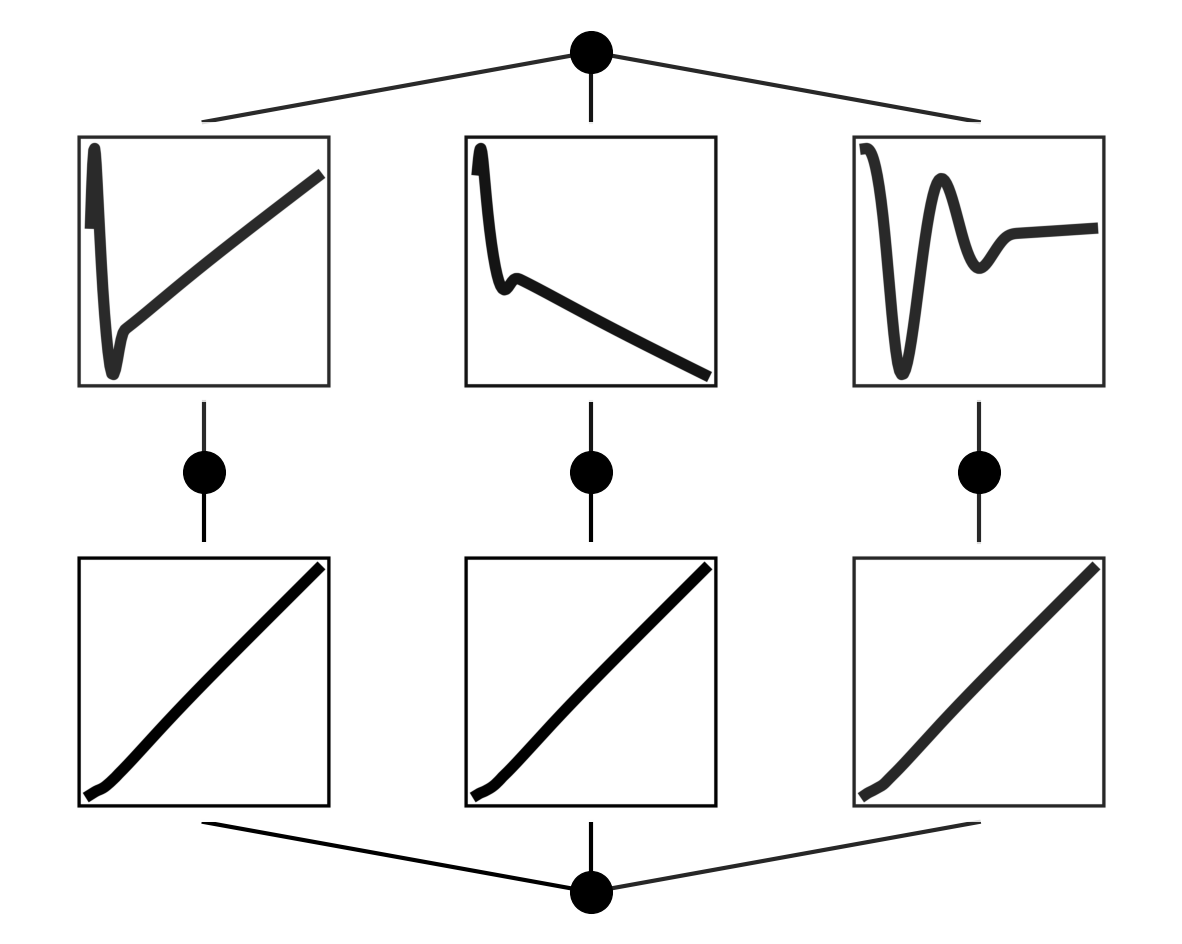

In [33]:
pinn.model.plot(scale = 1.5)

In [34]:
pinn.model.auto_symbolic()

fixing (0,0,0) with sigmoid, r2=0.999710738658905
fixing (0,0,1) with abs, r2=0.9997267127037048
fixing (0,0,2) with abs, r2=0.999696671962738
fixing (1,0,0) with gaussian, r2=0.643867552280426
fixing (1,1,0) with tan, r2=0.960663378238678
fixing (1,2,0) with gaussian, r2=0.6490557789802551


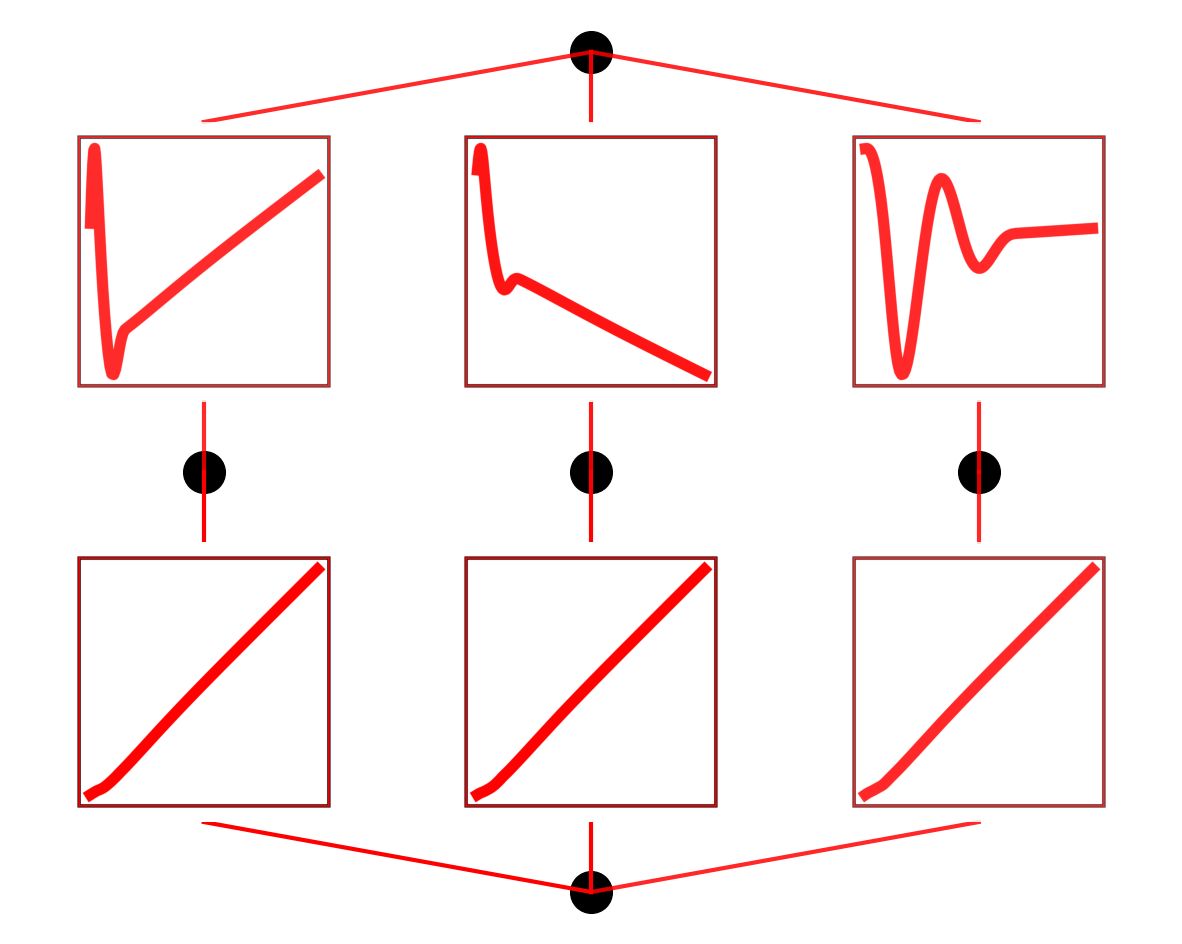

In [35]:
pinn.model.plot(scale = 1.5)

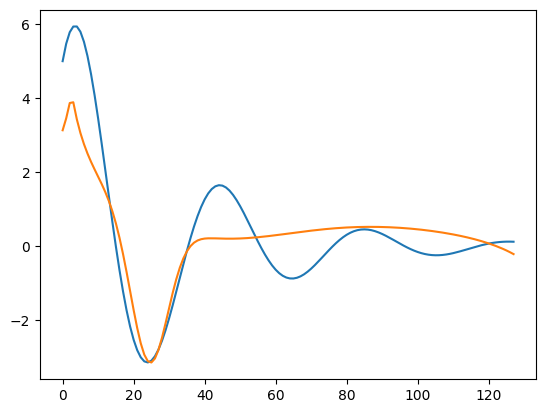

In [36]:
preds = pinn.predict(test).detach()
plt.plot(solution)
plt.plot(preds)

In [37]:
out = pinn.model.symbolic_formula()
f, x1 = out[0][0], out[1][0]

In [38]:
f

-0.52*tan(0.03*Abs(10.0*x_1 - 2.0) - 4.58) + 0.84 - 1.0*exp(-69.62*(sigmoid(0.8 - 0.17*x_1) - 0.58)**2) - 3.86*exp(-8.8*(1 - 0.06*Abs(9.73*x_1 - 2.0))**2)

Base:

$$e^{-0.4t}(4.59 \sin(1.96t) + 5 \cos(1.96t))$$

---

In [39]:
import sympy

aboba

NameError: name 'aboba' is not defined

In [ ]:
functions = [
    'x',
    'x^2',
    'x^3',
    'x^4',
    '1/x',
    '1/x^2',
    '1/x^3',
    '1/x^4',
    'sqrt(x)',
    '1/sqrt(x)',
    'exp',
    'log',
    'abs',
    'sin',
    'tan',
    'tanh = (exp(x) - exp(-x))/(exp(x) + exp(-x))',
    'sigmoid = 1/(1 + exp(-x))',
    # 'sgn',
    # 'arcsin',
    # 'arctan',
    # 'arctanh',
    # 'gaussian',
    # 'cosh'
 ]

torchlib = {
    'x':            lambda x: x,                          
    'x^2':          lambda x: x**2,                     
    'x^3':          lambda x: x**3,                     
    'x^4':          lambda x: x**4,                     
    '1/x':          lambda x: 1/x,                      
    '1/x^2':        lambda x: 1/x**2,                 
    '1/x^3':        lambda x: 1/x**3,                 
    '1/x^4':        lambda x: 1/x**4,                 
    'sqrt':         lambda x: torch.sqrt(x),           
    '1/sqrt(x)':    lambda x: 1/torch.sqrt(x),    
    'exp':          lambda x: torch.exp(x),             
    'log':          lambda x: torch.log(x),             
    'abs':          lambda x: torch.abs(x),             
    'sin':          lambda x: torch.sin(x),             
    'tan':          lambda x: torch.tan(x),             
    'tanh':         lambda x: torch.tanh(x),           
    'sigmoid':      lambda x: torch.sigmoid(x),     
    'sgn':          lambda x: torch.sign(x),            
    'arcsin':       lambda x: torch.arcsin(x),       
    'arctan':       lambda x: torch.arctan(x),       
    'arctanh':      lambda x: torch.arctanh(x),      
    'gaussian':     lambda x: torch.exp(-x**2),
    'cosh':         lambda x: torch.cosh(x),
}

symlib = {
    'x':            lambda x: x,
    'x^2':          lambda x: x**2,
    'x^3':          lambda x: x**3,
    'x^4':          lambda x: x**4,
    '1/x':          lambda x: 1/x,
    '1/x^2':        lambda x: 1/x**2,
    '1/x^3':        lambda x: 1/x**3,
    '1/x^4':        lambda x: 1/x**4,
    'sqrt':         lambda x: sympy.sqrt(x),
    '1/sqrt(x)':    lambda x: 1/sympy.sqrt(x),
    'exp':          lambda x: sympy.exp(x),
    'log':          lambda x: sympy.log(x),
    'abs':          lambda x: sympy.Abs(x),
    'sin':          lambda x: sympy.sin(x),
    'tan':          lambda x: sympy.tan(x),
    'tanh':         lambda x: sympy.tanh(x),
    'sigmoid':      sympy.Function('sigmoid'),
    'sgn':          lambda x: sympy.sign(x),
    'arcsin':       lambda x: sympy.asin(x),
    'arctan':       lambda x: sympy.atan(x),
    'arctanh':      lambda x: sympy.atanh(x),
    'gaussian':     lambda x: sympy.exp(-x**2),
    'cosh':         lambda x: sympy.cosh(x)
}

In [ ]:
from pysr import PySRRegressor

model = PySRRegressor(
    niterations=40,
    binary_operators=['+'],
    # unary_operators=list(torchlib.keys()),
    extra_torch_mappings=torchlib,
    extra_sympy_mappings=symlib,
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
)

model.fit(t.reshape(-1, 1), solution.reshape(-1, 1))

[ Info: Started!


PySRRegressor.equations_ = [
	   pick  score  equation      loss  complexity
	0  >>>>    0.0  0.290989  3.432547           1
]

In [ ]:
print(model)

PySRRegressor.equations_ = [
	   pick  score  equation      loss  complexity
	0  >>>>    0.0  0.291299  3.432547           1
]
